# RGB Gesture Recognition Example with Jesture Dataset



### Import Necessary Libraries

This cell imports essential libraries: Gradio for the interface, OpenCV for image processing, the Akida library for model execution, and NumPy and Plotly for data handling and visualization.

In [1]:
import gradio as gr
import cv2

from cnn2snn import set_akida_version, AkidaVersion
import akida

import numpy as np

import time

import plotly.graph_objects as go

/home/kmanninen/miniconda3/envs/akida_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-08-09 08:01:15.572047: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-09 08:01:15.616439: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-08-09 08:01:15.616481: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-08-0

### Gauge Creation Function

Defines a function using Plotly to create a gauge visualization for metrics such as frames per second during image classification.

In [2]:
def create_gauge(value):
    fig = go.Figure(go.Indicator(
        mode="gauge+number",
        value=value,
        gauge={'axis': {'range': [0, 30]}},
        domain={'x': [0, 1], 'y': [0, 1]},
    ))
    fig.update_layout(width=400, height=300)
    return fig

### Softmax Function for Arrays

Implements a softmax function to convert model outputs into probability distributions.

In [3]:
# Softmax for an array of values
def softmaxArray(values):
    # Assuming array shape is (1, 1, 1, x), flatten to get the values
    values = values.ravel()
    exp_values = np.exp(values)
    sum_exp = np.sum(exp_values)
    softmax_values = exp_values / sum_exp
    return softmax_values

### Image Configuration and Output Decoding

Sets up image parameters and label names, and includes a function to preprocess images and decode predictions into readable labels.

In [4]:
# Decode numeric labels into human readable ones: contains all string names for classes
# available in the dataset
import os
import csv
# Get current working directory
current_directory = os.getcwd()
# Construct full file path
file_path = os.path.join(current_directory, 'datasets/jester_subset', 'jester-v1-labels.csv')
# Open the file
with open(file_path, 'r') as csvfile:
    labels = [row[0] for row in csv.reader(csvfile)]

In [5]:
image_x = 100
image_y = 100
image_z = 3
def decodeOutput(inp):
        global akida_model
        inp = cv2.resize(inp, (image_x, image_y))
        inp = inp.reshape((-1, image_x, image_y, image_z))
        timer_start = time.time()
        predictions = softmaxArray(akida_model.predict(inp))
        frame_time = time.time() - timer_start
        fps = 1 / frame_time if frame_time > 0 else 0
        confidences = {labels[i]: predictions[i] for i in range(len(predictions))}
        sorted_confidences = dict(sorted(confidences.items(), key=lambda item: item[0]))

        # Get top prediction and send to AFrame
        top_gesture = max(confidences, key=confidences.get)
        confidence = confidences[top_gesture]

        gesture_key = top_gesture
        print(f"gesture_key: {gesture_key}, confidence: {confidence}, fps: {fps}")
        if confidence > 0.7:
                gesture_to_key = {
                'Swiping Up': 'ArrowUp',
                'Swiping Down': 'ArrowDown', 
                'Swiping Left': 'ArrowLeft',
                'Swiping Right': 'ArrowRight'
                }
                gesture_key = gesture_to_key.get(top_gesture, "")
                
                

        return sorted_confidences, fps, gesture_key

### Image Classification Wrapper

A function that processes an image, decodes it, and returns classification confidences with a gauge visualization of processing speed.

In [6]:
def classify_image(inp):

  confidences, fps, gesture_key = decodeOutput(inp)
  print(f"Gesture: {gesture_key}, FPS: {fps}")

  return confidences, create_gauge(round(fps, 2)), gesture_key

### Load Pre-trained Model

Loads a pre-trained quantized model for visual wake word detection via `akida_models`.

In [7]:
from akida_models.model_io import load_model
akida_model = load_model("models/tenn_spatiotemporal_jester_buffer_i8_w8_a8.fbz")
akida_model.summary()

                 Model Summary                  
________________________________________________
Input shape    Output shape  Sequences  Layers
[100, 100, 3]  [1, 1, 27]    1          18    
________________________________________________

_________________________________________________________________________
Layer (type)                            Output shape   Kernel shape    

================== SW/input_conv-dequantizer (Software) =================

input_conv (InputConv2D)                [50, 50, 8]    (3, 3, 3, 8)    
_________________________________________________________________________
convt_full_1_0 (BufferTempConv)         [50, 50, 20]   (1, 1, 40, 20)  
_________________________________________________________________________
convs_full_1_0 (Conv2D)                 [25, 25, 40]   (3, 3, 20, 40)  
_________________________________________________________________________
convt_full_2_0 (BufferTempConv)         [25, 25, 80]   (1, 1, 200, 80) 
__________________________

Map the `akida_model` onto the device.

In [8]:
with set_akida_version(AkidaVersion.v2):
            devices = akida.devices()
            if len(devices) > 0:
                print(f'Available devices: {[dev.desc for dev in devices]}')
                device = devices[0]
                print(device.version)
                try:
                    akida_model.map(device)
                    print(f"Mapping to Akida device {device.desc}.")
                    mappedDevice = device.version
                except Exception as e:
                    print("Model not compatible with FPGA. Running on CPU.")
                    mappedDevice = "CPU"
            else:
                print("No Akida devices found, running on CPU.")
                mappedDevice = "CPU"

No Akida devices found, running on CPU.


### Model Summary After Mapping

In [ ]:
akida_model.summary()

### Gradio Interface Setup

Creates a Gradio interface to capture webcam images, display device information, and stream classified images using the Akida model. The interface shows live predictions and frame processing speeds.

In [9]:
theme = gr.themes.Base(
    text_size="sm",
    spacing_size="sm",
    radius_size="sm",
)

gr.set_static_paths(paths=["games/"])



with gr.Blocks(
    title="Brainchip",
    fill_width=True,
    fill_height=True,
    delete_cache=[180, 600],
    theme=theme
) as demo:
    gr.Markdown("""
        <h1 style="text-align: center;">Akida Cloud</h1>
        <br>
        """)
    with gr.Row():
        gr.Markdown("## Image Classification")
    with gr.Row():
        with gr.Column():
            input_img = gr.Image(sources=["webcam"], type="numpy")
            gr.Markdown("**ℹ️ Please press the 'Record' button to start inference.**")
        with gr.Column():
            gr.Markdown(f"""Device: {mappedDevice}""")
            js_output = gr.HTML(visible=False)
            gesture_output = gr.Textbox(visible=True)
            aframe_component = gr.HTML("""
                <iframe src="/gradio_api/file=games/snake_game.html" 
                        width="800" height="600" 
                        frameborder="0"
                        id="aframe-iframe">
                </iframe>
            """)
            output_label = gr.Label(elem_classes=labels)
            #output_dataframe = gr.DataFrame(label="Classification Results", headers=["Label", "Confidence"]) 
            print(output_label)
            plot = gr.Plot(label="Frames per second")
        dep = input_img.stream(classify_image, [input_img], [output_label, plot, gesture_output],
                                time_limit=30, stream_every=0.1, concurrency_limit=30)      
        gesture_output.change(
            fn=None,
            js="""(gesture) => {
                                    console.log('Gesture key:', gesture);
                                    // Send gesture to AFrame iframe
                                    if (gesture && gesture.trim() !== '') {
                                        console.log('Sending gesture during stream:', gesture);
                                        let iframe = document.getElementById('aframe-iframe');
                                        if (iframe) {
                                            iframe.contentWindow.postMessage({
                                                type: 'gesture',
                                                keyCode: gesture
                                            }, '*');
                                        }
                                    }
                                    return outputs;
                                }""",
            inputs=[gesture_output], outputs=[]
        )
        


if __name__ == "__main__":
    demo.launch()

* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.


gesture_key: Doing other things, confidence: 0.0743890330195427, fps: 40.638149034502135
Gesture: Doing other things, FPS: 40.638149034502135
gesture_key: Sliding Two Fingers Left, confidence: 0.16794629395008087, fps: 17.26214415356186
Gesture: Sliding Two Fingers Left, FPS: 17.26214415356186
gesture_key: Pushing Hand Away, confidence: 0.15696394443511963, fps: 24.155310730884192
Gesture: Pushing Hand Away, FPS: 24.155310730884192
gesture_key: Pushing Hand Away, confidence: 0.16276057064533234, fps: 53.846995237055964
Gesture: Pushing Hand Away, FPS: 53.846995237055964
gesture_key: Doing other things, confidence: 0.2442258596420288, fps: 43.932754448994984
Gesture: Doing other things, FPS: 43.932754448994984
gesture_key: Doing other things, confidence: 0.13044323027133942, fps: 48.517108155002894
Gesture: Doing other things, FPS: 48.517108155002894
gesture_key: No gesture, confidence: 0.3559068441390991, fps: 41.748907579754146
Gesture: No gesture, FPS: 41.748907579754146
gesture_key:

#### Note: Once you’ve finished running the notebook, ***"Uncomment and run the cell below"*** to release the device and free it up for further experiments.

In [ ]:
# import os
# os._exit(00)

#### You can also use this button to reset your kernel

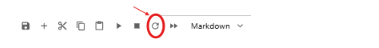